In [28]:
import pandas as pd
import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.models import KeyedVectors, Word2Vec, phrases
from gensim.parsing import preprocessing
from gensim.parsing.preprocessing import strip_tags, strip_punctuation,strip_numeric,remove_stopwords
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel
from os import walk
from os import listdir
from os.path import isfile, join

from pprint import pprint

import pickle

from matplotlib import pyplot as plt

import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors

In [29]:
#  Clean data
def text_cleaning(data):
    new_sentences = []
    filters = [lambda x: x.lower(), strip_tags, strip_punctuation,strip_numeric,remove_stopwords]
    no_findings = []
    for i in range(data.shape[0]):
        txt = data.iloc[i]
        c_words = []
        words = preprocessing.preprocess_string(txt, filters)
        for w in words:
            if len(w)>3 :
                c_words.append(w)
            new_sentences.append(c_words)
    
    return new_sentences



In [ ]:
#### Insights
'''
10+ topics seems to be a large and not an optimal number. For homework porpuses, I left with 10.
However, based on the distribution of words per topic and it's frequence, it does not seems like we're creating good 
clusters. 

From the clusters we have, we do notice a representation of the data in many different ways. For example:
Topic 8: It does seems to be looking at cancer and words related to it
Topic 7: About healthcare
Topic 6: Talking about resilience, survival.
and so on.

Findings can be seen in the code bellow
'''

In [3]:
data = pd.read_csv("Breast_Cancer.csv")['Text']
sentences = text_cleaning(data)
sentences[:10]

[['worked', 'dying', 'stage', 'breast', 'cancer', 'paid', 'pocket'],
 ['worked', 'dying', 'stage', 'breast', 'cancer', 'paid', 'pocket'],
 ['worked', 'dying', 'stage', 'breast', 'cancer', 'paid', 'pocket'],
 ['worked', 'dying', 'stage', 'breast', 'cancer', 'paid', 'pocket'],
 ['worked', 'dying', 'stage', 'breast', 'cancer', 'paid', 'pocket'],
 ['worked', 'dying', 'stage', 'breast', 'cancer', 'paid', 'pocket'],
 ['worked', 'dying', 'stage', 'breast', 'cancer', 'paid', 'pocket'],
 ['worked', 'dying', 'stage', 'breast', 'cancer', 'paid', 'pocket'],
 ['worked', 'dying', 'stage', 'breast', 'cancer', 'paid', 'pocket'],
 ['drug', 'breast', 'cancer', 'month', 'afford', 'spending']]

In [4]:
# create Bigrams
bigram = gensim.models.Phrases(sentences) 
bigram_mod = gensim.models.phrases.Phraser(bigram)
data_ready = [bigram_mod[doc] for doc in sentences]
data_ready[80:100]

[['saved',
  'breast',
  'cancer',
  'survivor',
  'bankruptcy_worse',
  'americans',
  'love',
  'obamacare_quit',
  'trying_sabotage',
  'premiums',
  'come_saveaca'],
 ['saved',
  'breast',
  'cancer',
  'survivor',
  'bankruptcy_worse',
  'americans',
  'love',
  'obamacare_quit',
  'trying_sabotage',
  'premiums',
  'come_saveaca'],
 ['saved',
  'breast',
  'cancer',
  'survivor',
  'bankruptcy_worse',
  'americans',
  'love',
  'obamacare_quit',
  'trying_sabotage',
  'premiums',
  'come_saveaca'],
 ['saved',
  'breast',
  'cancer',
  'survivor',
  'bankruptcy_worse',
  'americans',
  'love',
  'obamacare_quit',
  'trying_sabotage',
  'premiums',
  'come_saveaca'],
 ['saved',
  'breast',
  'cancer',
  'survivor',
  'bankruptcy_worse',
  'americans',
  'love',
  'obamacare_quit',
  'trying_sabotage',
  'premiums',
  'come_saveaca'],
 ['saved',
  'breast',
  'cancer',
  'survivor',
  'bankruptcy_worse',
  'americans',
  'love',
  'obamacare_quit',
  'trying_sabotage',
  'premiums',

In [5]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

In [6]:
def build_LDA(corpus, id2word, num_topics=10, update_every=1, chunksize=10, passes=10, 
              alpha='symmetric',iterations=100,per_word_topics=True):
    
    model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           update_every=update_every,
                                           chunksize=chunksize,
                                           passes=passes,
                                           alpha=alpha,
                                           iterations=iterations,
                                           per_word_topics=per_word_topics)
    
    return model

In [7]:
lda_model = build_LDA(corpus,id2word, num_topics=15)
num_topics = 15

# lda_model = build_LDA(corpus,id2word, num_topics=15)
# lda_model = build_LDA(corpus,id2word, num_topics=20)

In [8]:
def format_topics_sentences( corpus, texts, ldamodel=None):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [9]:
df_topic_sents_keywords = format_topics_sentences( corpus, data_ready, ldamodel=lda_model)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)


Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             8.0              0.3434   
1            1             8.0              0.3434   
2            2             8.0              0.3435   
3            3             8.0              0.3434   
4            4             8.0              0.3434   
5            5             8.0              0.3434   
6            6             8.0              0.3434   
7            7             8.0              0.3434   
8            8             8.0              0.3433   
9            9             8.0              0.4445   

                                            Keywords  \
0  cancer, breast, breastcancer, survivor, years,...   
1  cancer, breast, breastcancer, survivor, years,...   
2  cancer, breast, breastcancer, survivor, years,...   
3  cancer, breast, breastcancer, survivor, years,...   
4  cancer, breast, breastcancer, survivor, years,...   
5  cancer, breast, breastcancer, survivor, years,...   
6  cancer, breast, breastcancer, survivor, years,...   
7  cancer, breast, breastcancer, survivor, years,...   
8  cancer, breast, breastcancer, survivor, years,...   
9  cancer, breast, breastcancer, survivor, years,...   

                                                Text  
0  [worked, dying, stage, breast, cancer, paid, p...  
1  [worked, dying, stage, breast, cancer, paid, p...  
2  [worked, dying, stage, breast, cancer, paid, p...  
3  [worked, dying, stage, breast, cancer, paid, p...  
4  [worked, dying, stage, breast, cancer, paid, p...  
5  [worked, dying, stage, breast, cancer, paid, p...  
6  [worked, dying, stage, breast, cancer, paid, p...  
7  [worked, dying, stage, breast, cancer, paid, p...  
8  [worked, dying, stage, breast, cancer, paid, p...  
9    [drug, breast, cancer, month, afford, spending]

In [10]:
# Get most representative sentence for each topic
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.1000   
1        1.0              0.7710   
2        2.0              0.6799   
3        3.0              0.7379   
4        4.0              0.8417   
5        5.0              0.7769   
6        6.0              0.7578   
7        7.0              0.7931   
8        8.0              0.9589   
9        9.0              0.1000   

                                                                                              Keywords  \
0  poppin_pills, child, bloomberg_advertisements, stay_tuned, patient_centered, impact, univsurg_gd...   
1  praying, healthy, jeopardy_praying, things_feelings, glutting_prayer, saying, titties_sumin, xcb...   
2  brain_tumor, waiting, tnbc, tamoxifen, broke, guess, ignorant, triggers_xfespecially, understand...   
3  starts, lovely, gonna, nice, power, aren_option, crowdfund_kick, lots_folk, learnt, continue_cha...   
4  breastcancerawareness, thoughts, helped, paid, needed, dohertyshannen, selfcare, medication, sor...   
5  worldcancerday, primary, line, raise, checkyourboobs_bookyoursmear, alive_hopeful, iamandiwill, ...   
6  death_sentence, treated, recovery_advanced, witnessing_beating, access, certainly_survival, jejo...   
7                               care, stage, told, healthcare, real, brain, free, cancer, clean, early   
8                  cancer, breast, breastcancer, survivor, years, people, like, know, treatment, today   
9  poppin_pills, child, bloomberg_advertisements, stay_tuned, patient_centered, impact, univsurg_gd...   

                                                                                   Representative Text  
0  [treatmenttuesday_lunch, courtesy_culinarycare, rpmitalianchi_thanks, appreciated_abraxane, here...  
1  [needlenymph_sherrirosen, manyfeathers_drdanacohen, bestboomer_iona, austinventureny_artsinnewyo...  
2                      [join, tomorrow_btbyoga, relaxing_evening, breastcancer, breastcancersurvivors]  
3  [lost, learnt, breastcancer, sense_humour, power, thoughts, lots_folk, crowdfund_kick, starts, a...  
4  [beth_metupukorg, created_comprehensive, database_unpaid, volunteer_ncri, partners_listening, so...  
5  [time, round, breastcancernow_wyhpartnership, delighted_service, pledge_programme, improving, br...  
6  [ladies_flooded, inbox_don’t, drink_interested, consuming_alcohol, anymore_alcohol, actually_rai...  
7  [incessantly_radiating, caused, breast, cancer, inject_airline, diego_dulles, beast_attempted, p...  
8  [thomaslenin_alex, marcy_rebeccanagle, berniesback_saying, white, women, breastcancer, white, pe...  
9  [treatmenttuesday_lunch, courtesy_culinarycare, rpmitalianchi_thanks, appreciated_abraxane, here...

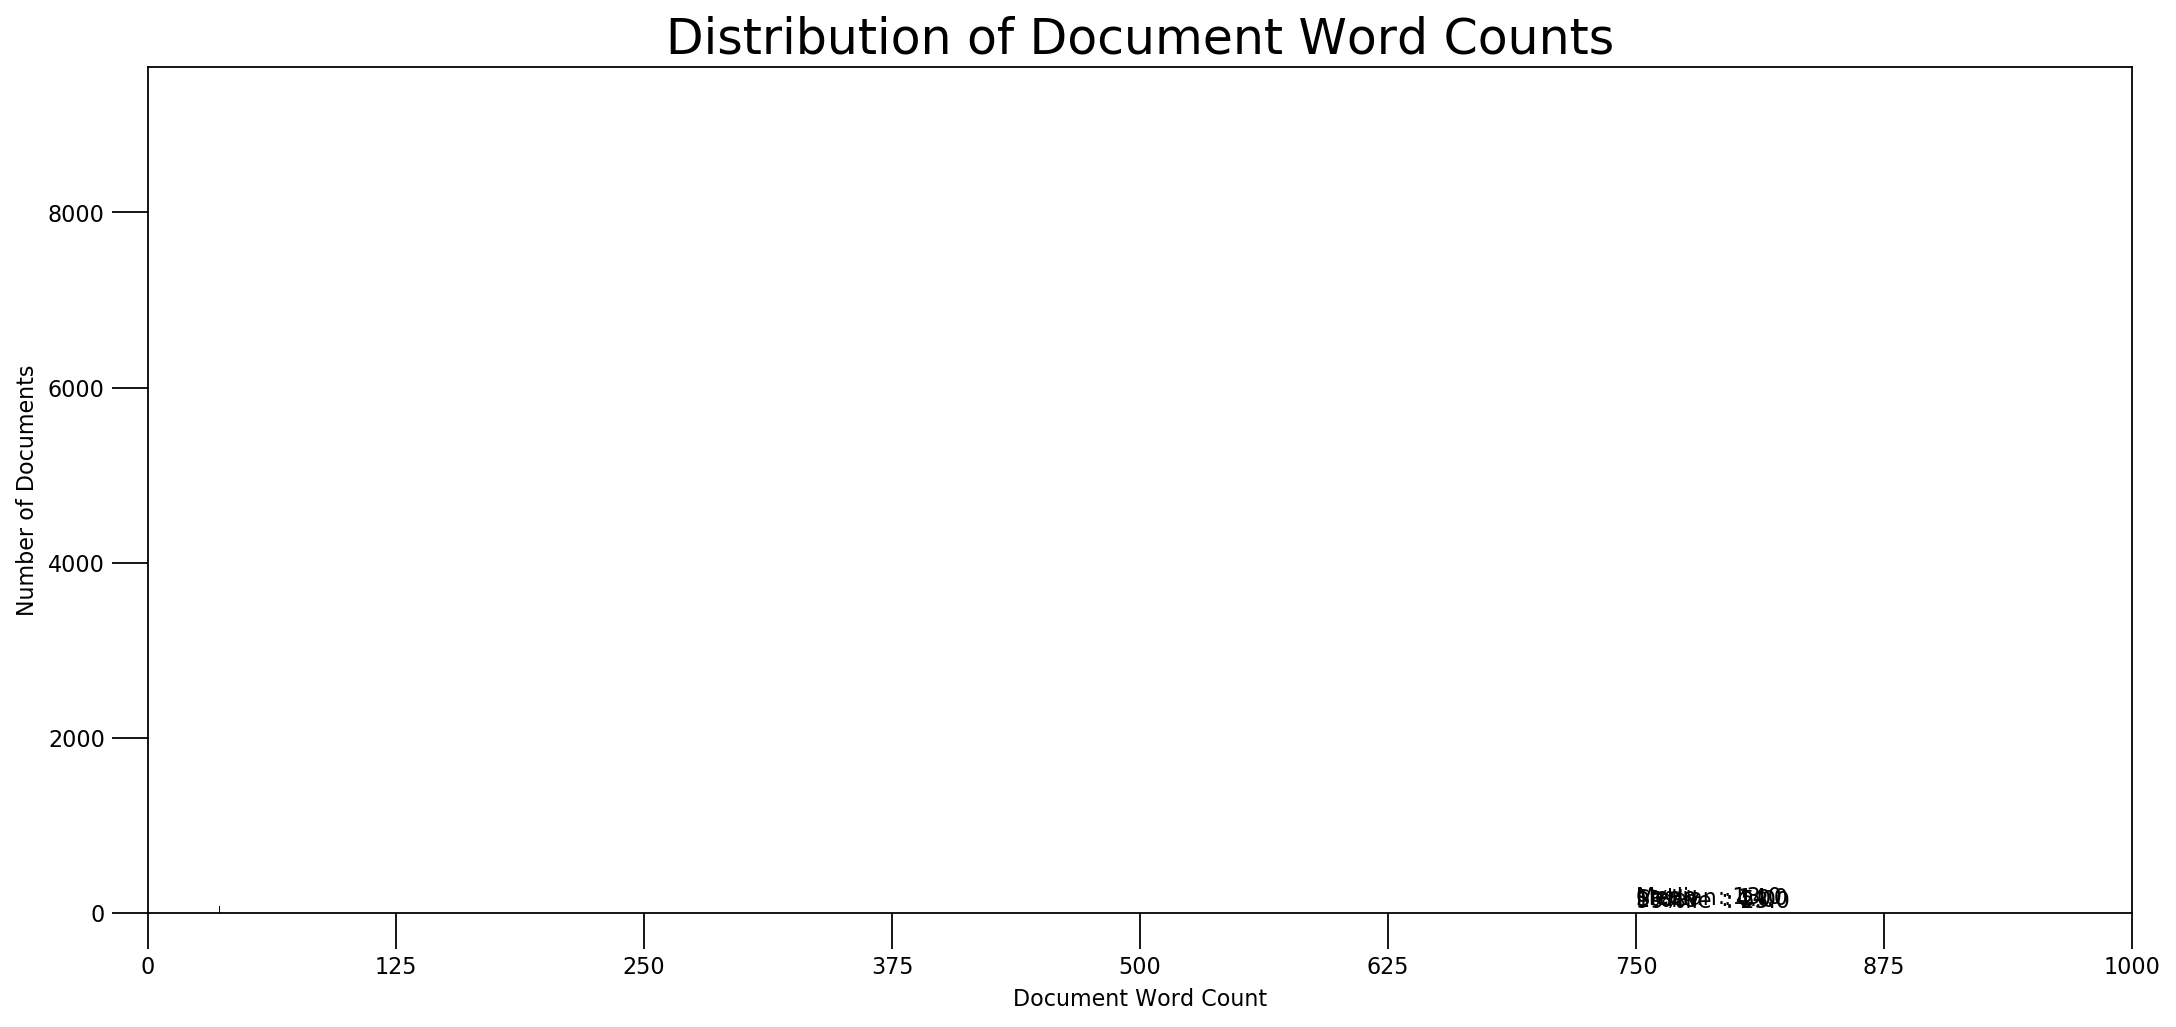

In [11]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:288: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


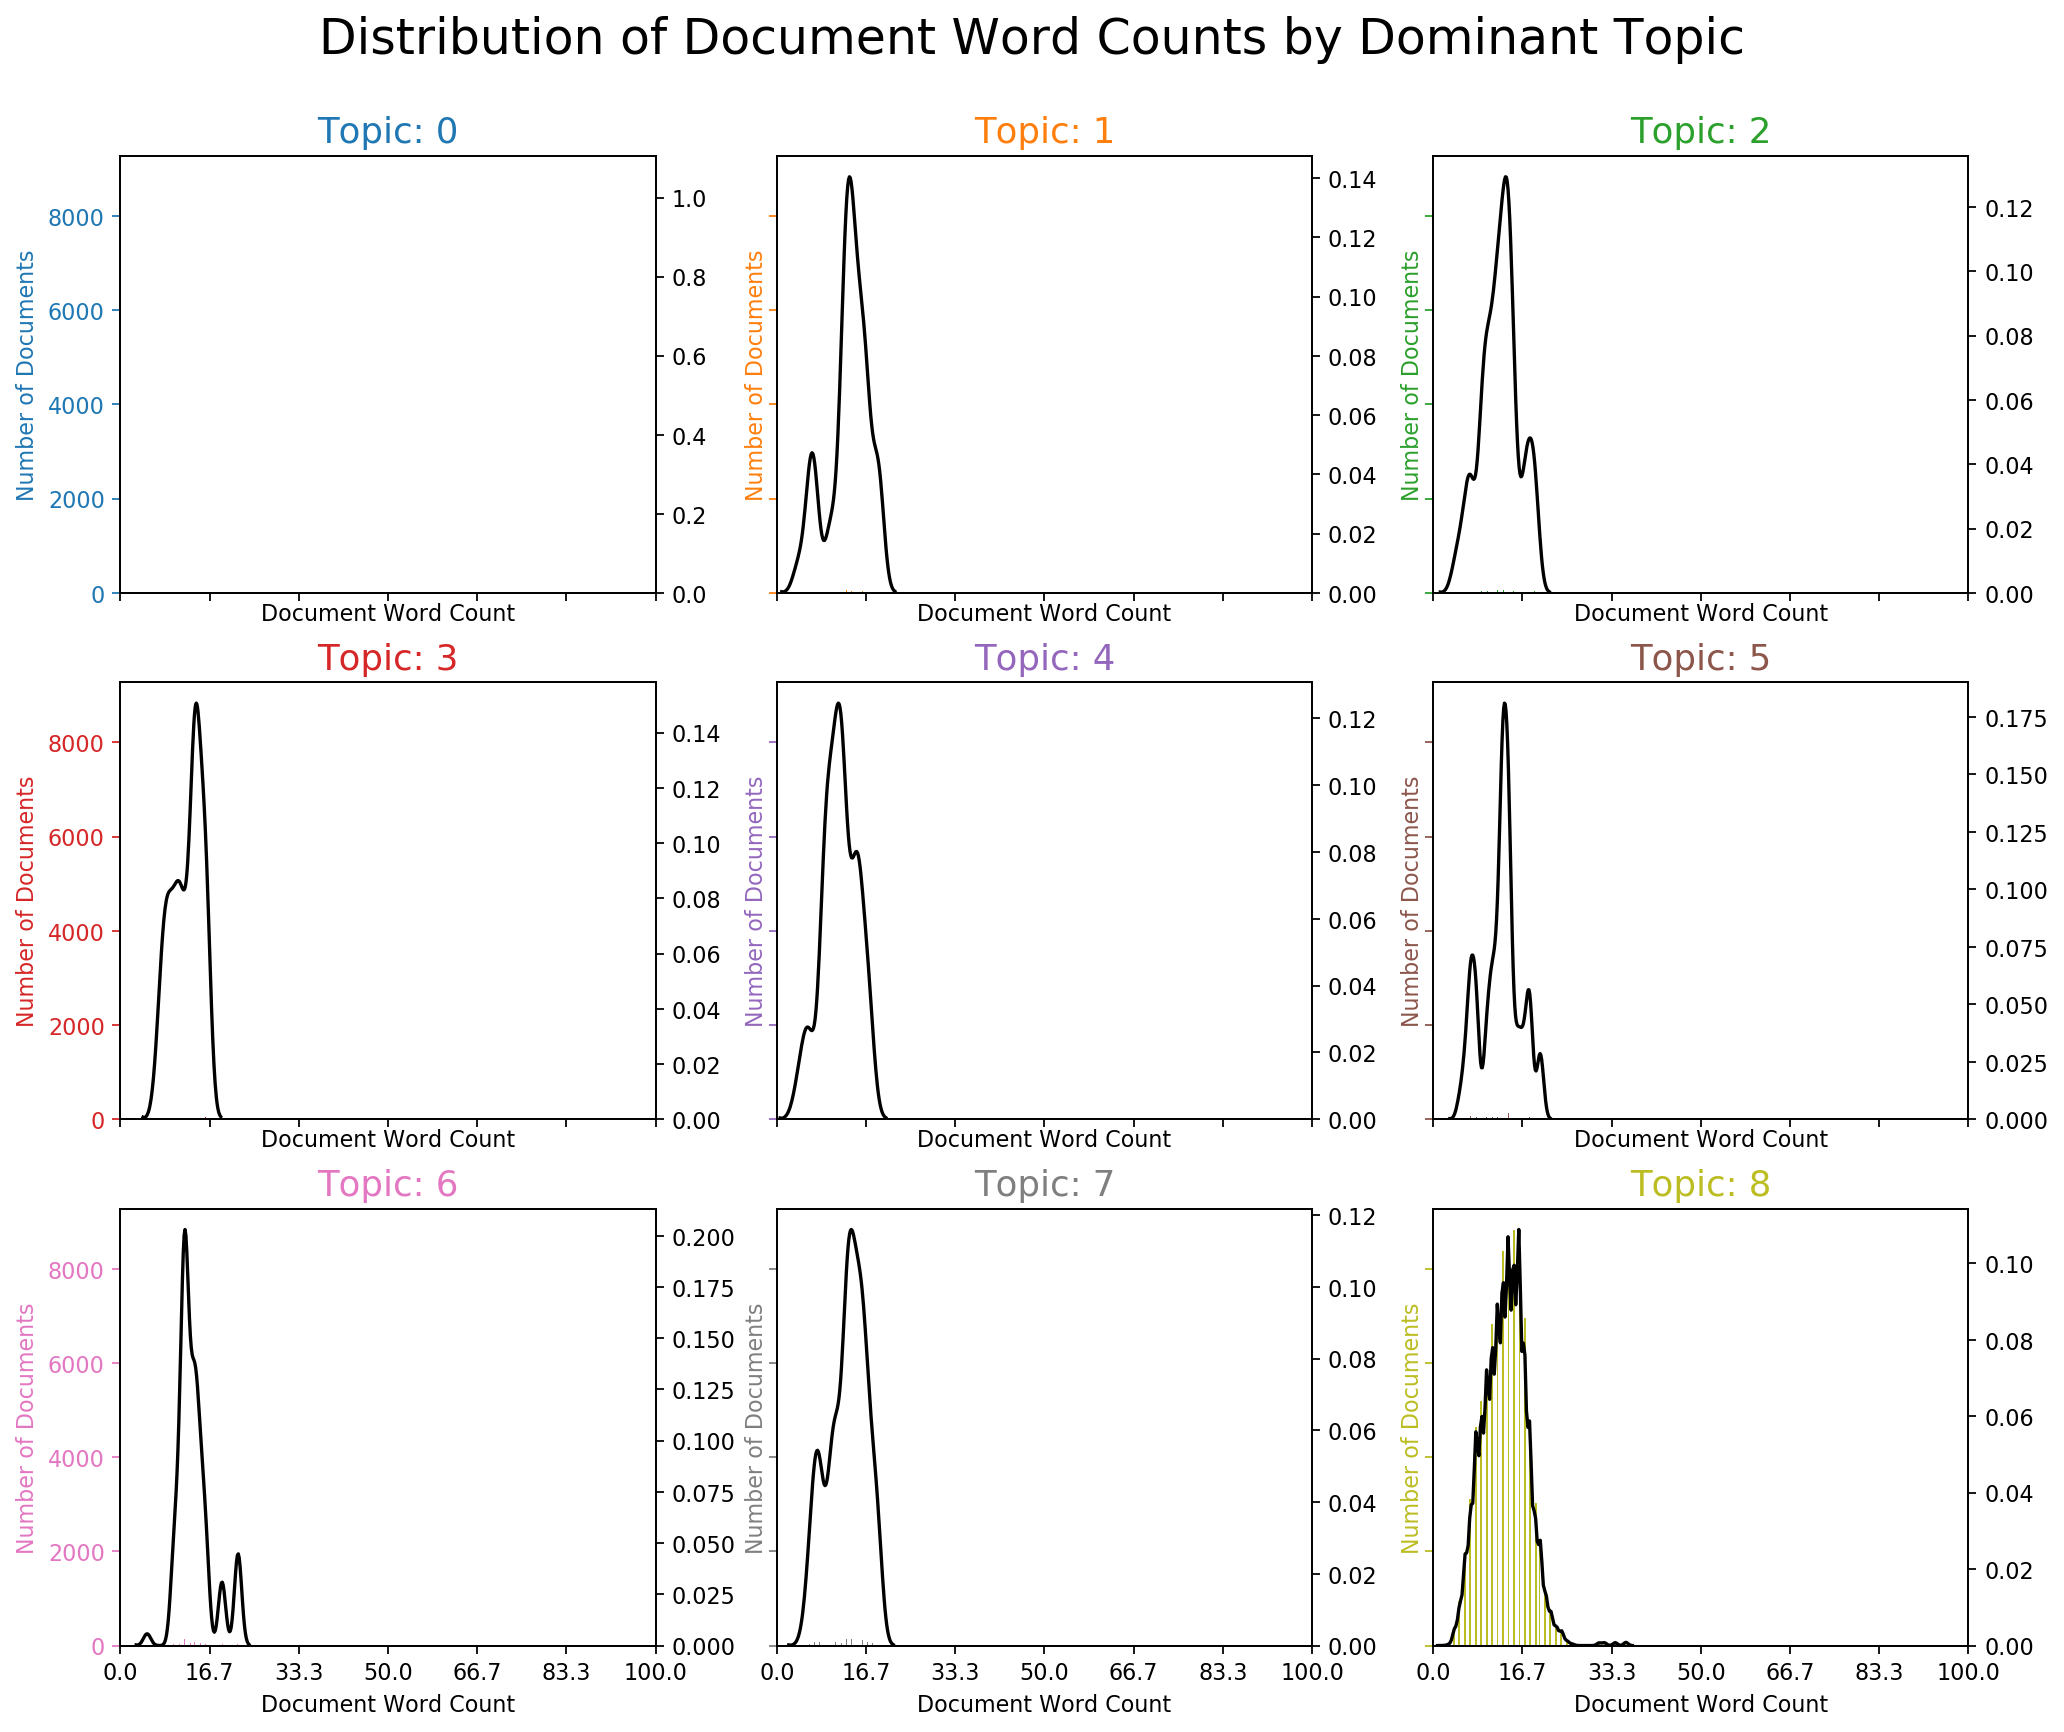

In [20]:

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

y = num_topics//3
x = num_topics//y
fig, axes = plt.subplots(x,y,figsize=(13,11), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 100), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,100,7))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

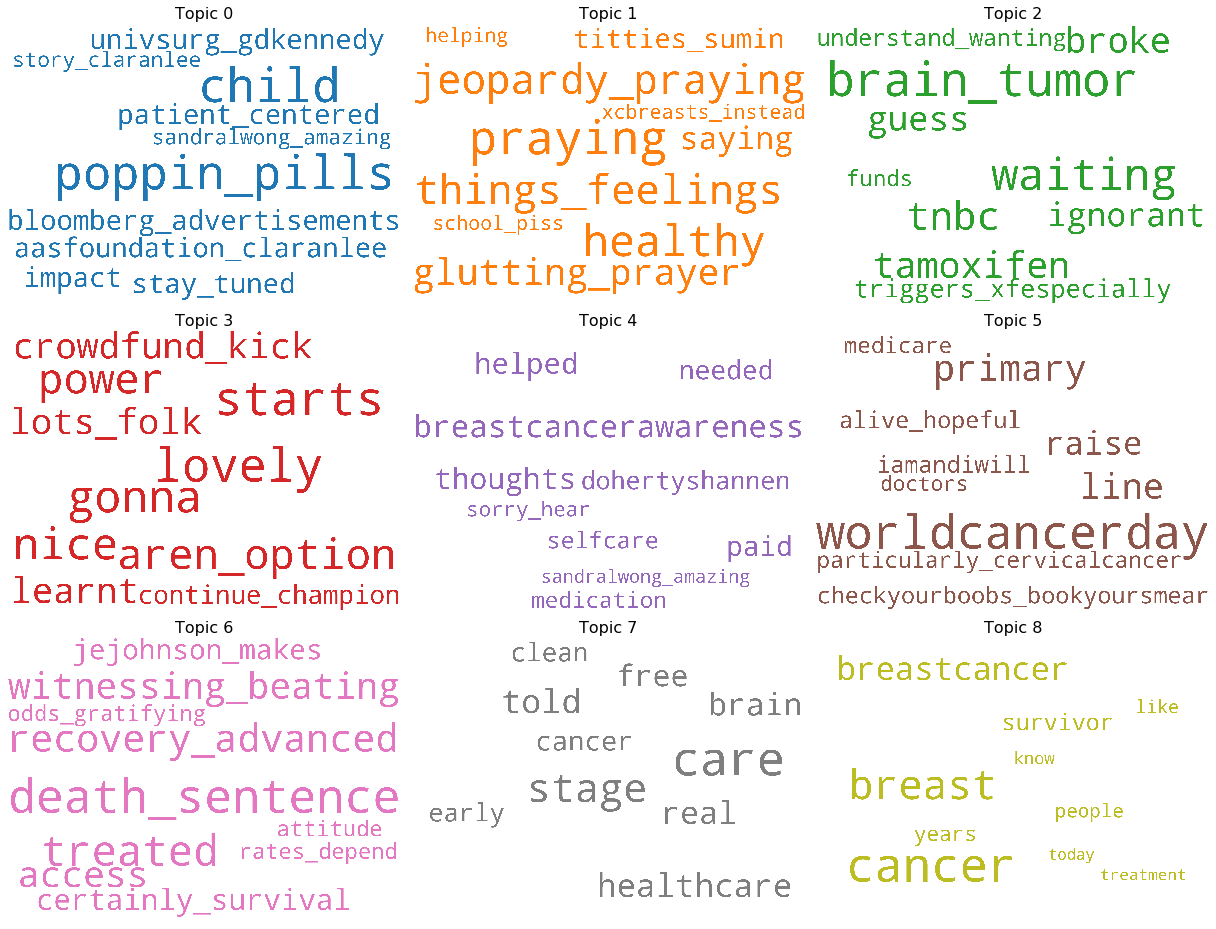

In [15]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=STOPWORDS,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

y = num_topics//3
x = num_topics//y

fig, axes = plt.subplots(x, y, figsize=(17,13), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

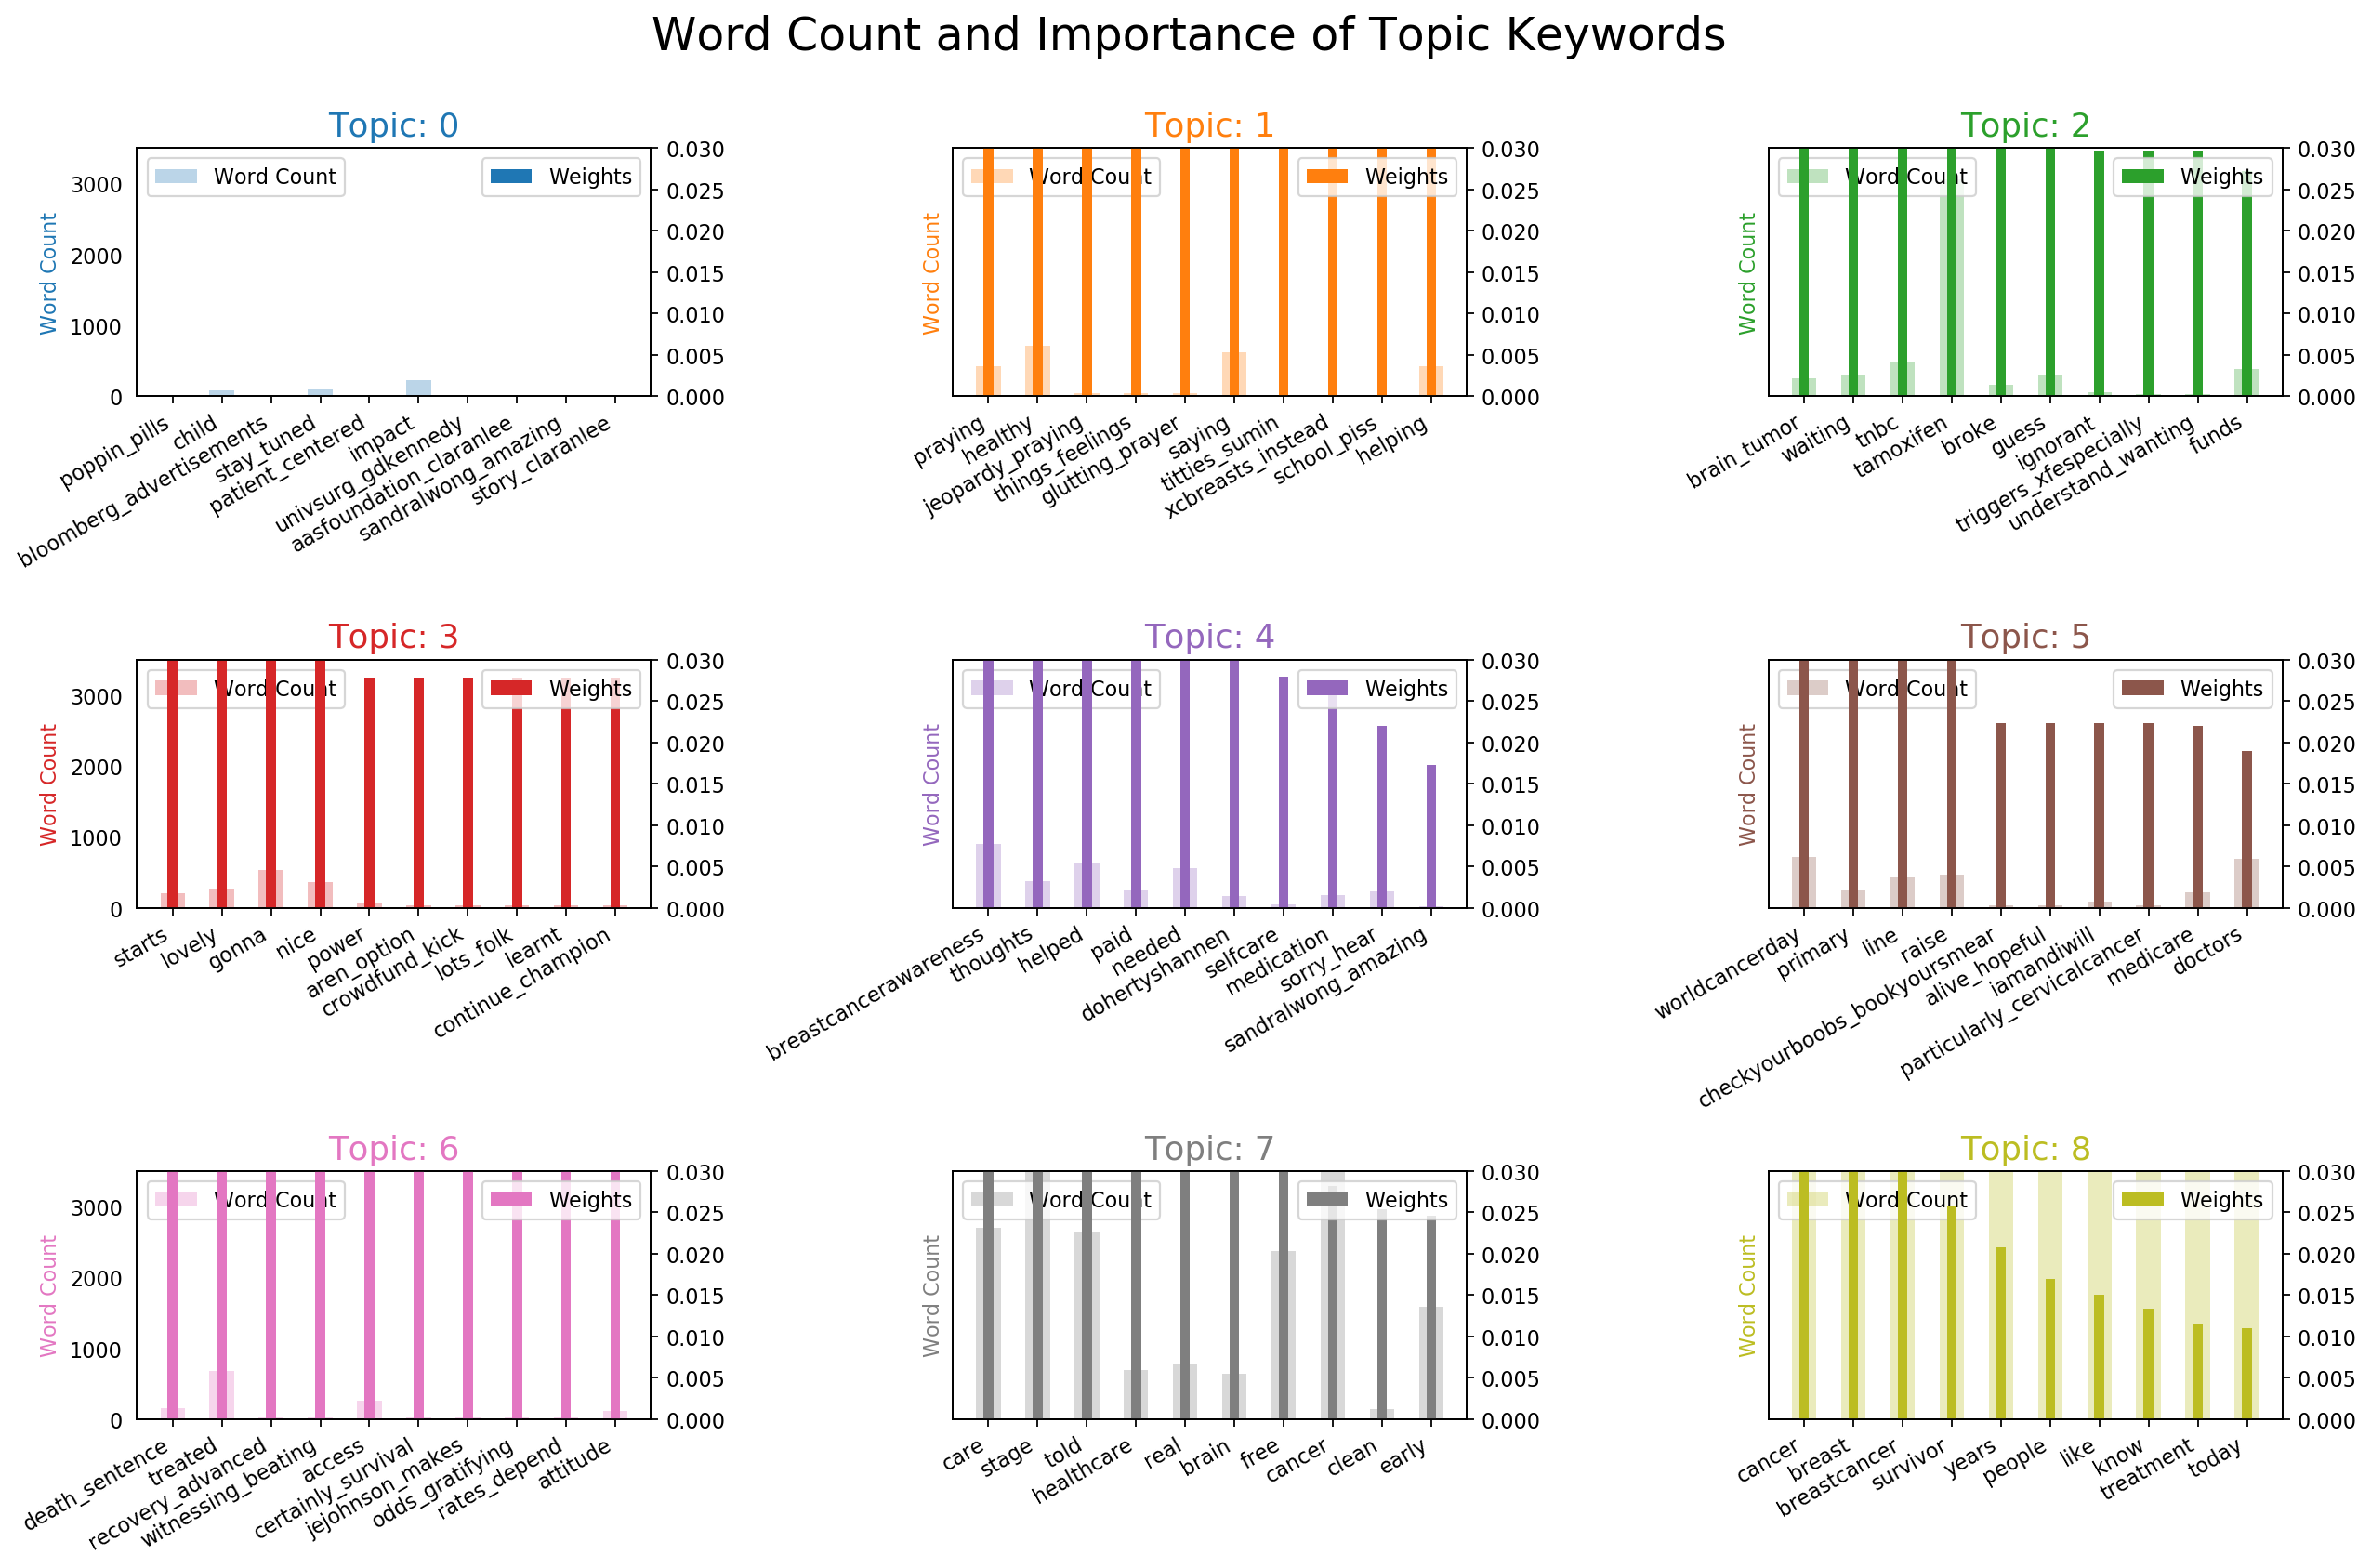

In [16]:
# Word Counts of Topic Keywords
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
y = num_topics//3
x = num_topics//y
fig, axes = plt.subplots(x, y, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [21]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

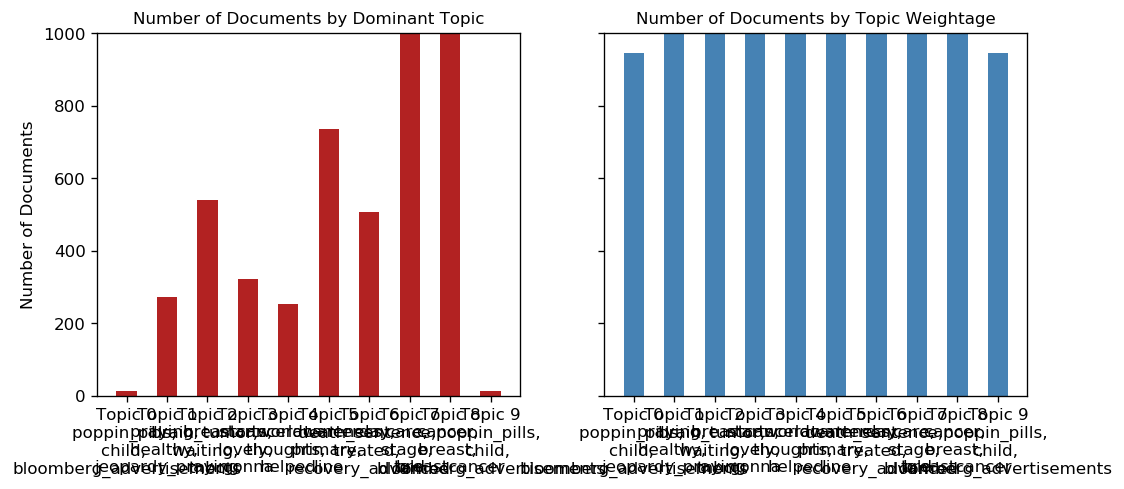

In [22]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [ ]:
#t-SNE Clustering Chart

In [23]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = num_topics
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 94297 samples in 0.074s...
[t-SNE] Computed neighbors for 94297 samples in 1.891s...
[t-SNE] Computed conditional probabilities for sample 1000 / 94297
[t-SNE] Computed conditional probabilities for sample 2000 / 94297
[t-SNE] Computed conditional probabilities for sample 3000 / 94297
[t-SNE] Computed conditional probabilities for sample 4000 / 94297
[t-SNE] Computed conditional probabilities for sample 5000 / 94297
[t-SNE] Computed conditional probabilities for sample 6000 / 94297
[t-SNE] Computed conditional probabilities for sample 7000 / 94297
[t-SNE] Computed conditional probabilities for sample 8000 / 94297
[t-SNE] Computed conditional probabilities for sample 9000 / 94297
[t-SNE] Computed conditional probabilities for sample 10000 / 94297
[t-SNE] Computed conditional probabilities for sample 11000 / 94297
[t-SNE] Computed conditional probabilities for sample 12000 / 94297
[t-SNE] Computed conditional probabilities for sam

Loading BokehJS ...